In [2]:
from pathlib import Path
from tqdm import tqdm
import numpy as np
import json
import urllib
import PIL.Image as Image
import cv2
import torch
import torchvision
from IPython.display import display
from sklearn.model_selection import train_test_split
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import os, shutil

In [2]:
#!pip install seaborn

     |████████████████████████████████| 285 kB 9.1 MB/s eta 0:00:01


In [23]:
### Little Formatting

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 16, 10
np.random.seed(42)


/home/ubuntu/Downloads/Object_detection-SuperMarket


In [24]:
### Each line in annotation file contains bounding box of a object in that file
### Extract bounding box of each object in a image file
bounding_boxes={}
with open('annotations.txt', 'r') as f:
    for line in f:
        if 'jpg' in line:
            line=line.split(',')
            if line[0] not in bounding_boxes:
                bounding_boxes[line[0]]=[line[1:]]
            else:
                bounding_boxes[line[0]].append(line[1:])
            
            

In [25]:
len(bounding_boxes.keys())

3151

In [26]:
### total iamges are 3153
### which implies , two images do not have any bounding boxes
def Diff(li1, li2):
    return list(set(li1) - set(li2)) + list(set(li2) - set(li1))
keys=[]
for key in bounding_boxes.keys():
    keys.append(int(key[key.find('b')+1:key.find('.')]))
        
res=Diff(list(range(1,3154)),keys)
res

[2444, 3044]

images db2444.jpg and db3044.jpg do not have any bounding boxes

In [30]:
### Creating single folder of images
folders=[x for x in os.listdir() if 'db' in x]
folders
if not os.path.exists('images'):
    os.mkdir('images')
for folder in folders:
    files=[x for x in os.listdir(folder) if x.endswith('.jpg')]
    for file in files:
        shutil.copy(os.path.join(folder,file), 'images')
    
    

In [27]:
###  Train test split
images_and_boxes=[[k,v] for k , v in bounding_boxes.items()]
train_images, test_images = train_test_split(images_and_boxes, test_size=0.1)

len(train_images), len(test_images)

(2835, 316)

In [28]:
## Train and validation split
train_images, valid_images = train_test_split(train_images, test_size=0.2)
len(train_images), len(valid_images)

(2268, 567)

In [29]:
train_images[0]

['db119.jpg',
 [['1', '4', '126', '420', 'object\n'],
  ['133', '1', '271', '420', 'object\n'],
  ['274', '1', '436', '432', 'object\n'],
  ['451', '1', '621', '437', 'object\n'],
  ['633', '5', '811', '462', 'object\n'],
  ['911', '7', '1093', '467', 'object\n'],
  ['1168', '1', '1306', '465', 'object\n'],
  ['1323', '1', '1513', '525', 'object\n'],
  ['1545', '5', '1721', '532', 'object\n'],
  ['1751', '1', '1903', '542', 'object\n'],
  ['1946', '77', '2123', '535', 'object\n'],
  ['2126', '60', '2181', '452', 'object\n'],
  ['648', '880', '918', '1447', 'object\n'],
  ['1098', '700', '1291', '1197', 'object\n'],
  ['1556', '797', '1788', '1347', 'object\n'],
  ['1306', '775', '1528', '1325', 'object\n'],
  ['1909', '955', '2176', '1552', 'object\n'],
  ['2175', '844', '2271', '1397', 'object\n'],
  ['6', '952', '211', '1415', 'object\n'],
  ['78', '845', '238', '952', 'object\n'],
  ['1', '737', '133', '832', 'object\n'],
  ['136', '757', '293', '842', 'object\n'],
  ['208', '660', 

In [30]:
### demo Image
def show_image(row):
    img = cv2.cvtColor(cv2.imread(f'images/{row[0]}'), cv2.COLOR_BGR2RGB)
    print(img.shape)
    for cordinates in row[1]:
        x1,y1,x2,y2=cordinates[:4]
        cv2.rectangle(img,(int(x1), int(y1)),(int(x2), int(y2)),color=(0, 255, 0),thickness=2)
        plt.imshow(img)
        plt.axis('off')

(1704, 2272, 3)


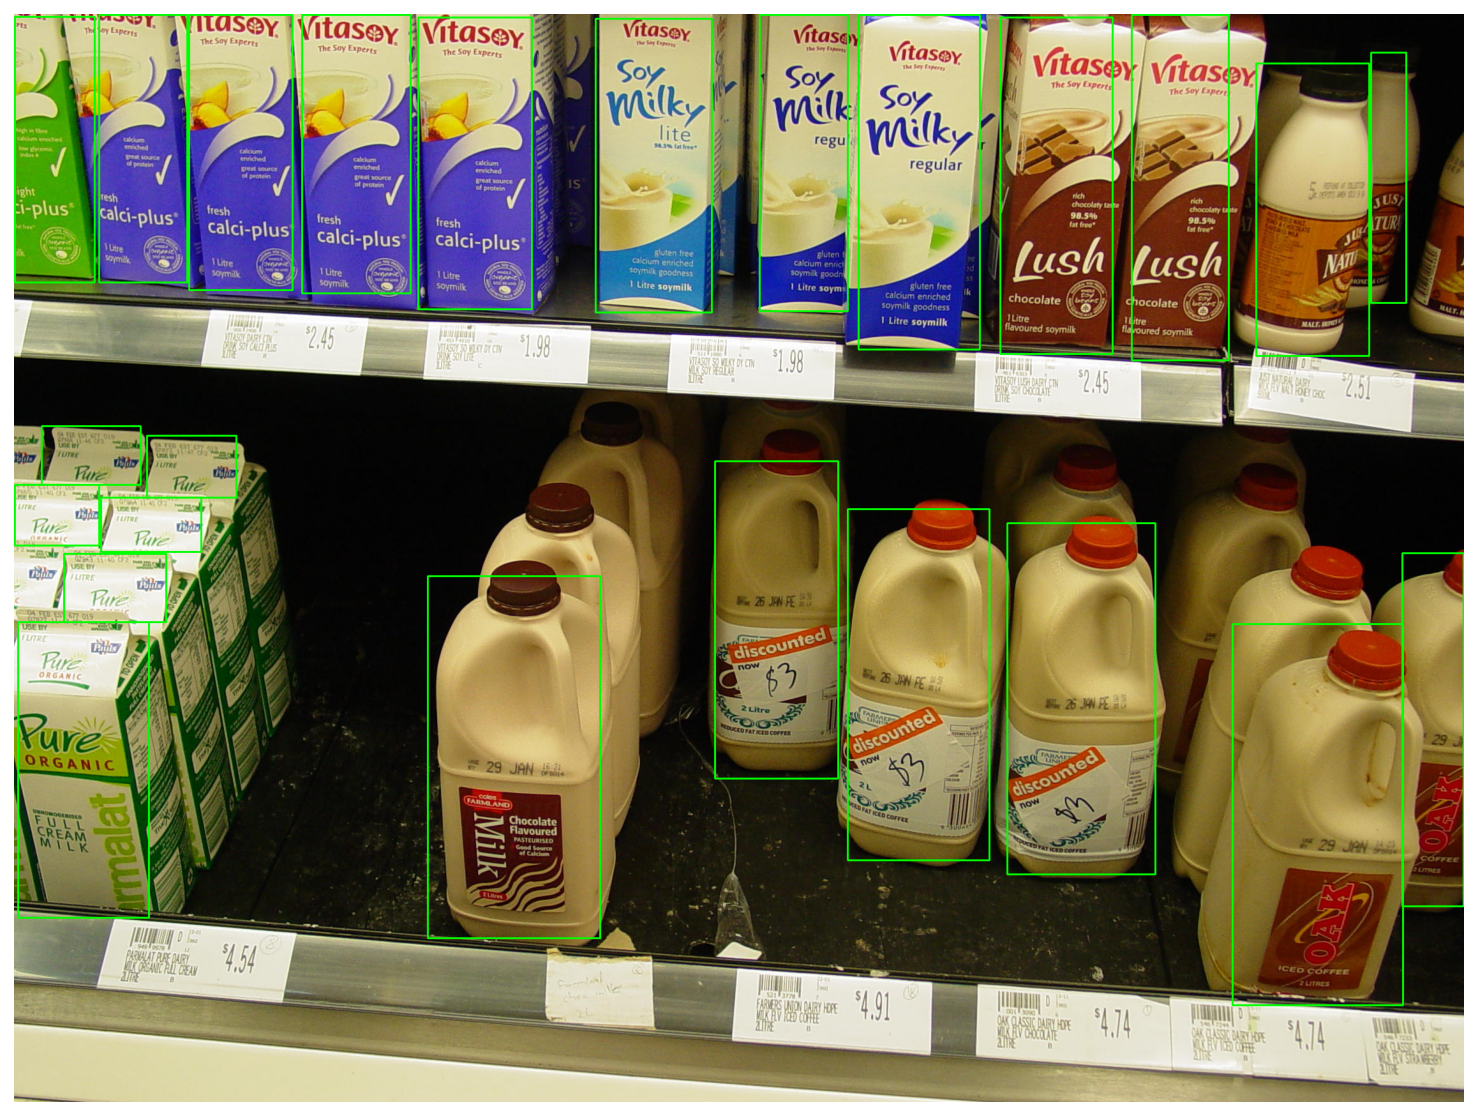

In [31]:
show_image(train_images[0])

Convert to YOLO format

YOLO v5 requires the dataset to be in the darknet format. Here’s an outline of what it looks like:

    One txt with labels file per image
    One row per object
    Each row contains: class_index bbox_x_center bbox_y_center bbox_width bbox_height
    Box coordinates must be normalized between 0 and 1

In [32]:
### Build Dataset in correct format
print(len(train_images), len(valid_images), len(test_images))

def create_dataset(images, dataset_type):
    
    images_path = Path(f"SuperMarket/images/{dataset_type}")
    images_path.mkdir(parents=True, exist_ok=True)
    labels_path = Path(f"SuperMarket/labels/{dataset_type}")
    labels_path.mkdir(parents=True, exist_ok=True)
    
    for img_id, row in enumerate(tqdm(images)):
        
        # Saving images in their respective folders
        image_name = f"{img_id}.jpg"
        img = Image.open(f'images/{row[0]}')
        img = img.convert("RGB")
        width, height = img.size
        img=img.resize((720,540))
        img.save(os.path.join(images_path,image_name))
        
        # Saving labels (bounding boxes) in their respective folders and respective files
        label_name = f"{img_id}.txt"
        with open(os.path.join(labels_path,label_name),mode="w") as label_file:
            for coordinates in row[1]:
                x1,y1,x2,y2=map(int, coordinates[:4])
                ## Translating points after reshaping 
                x1,y1,x2,y2=(x1/width)*720, (y1/height)*540, (x2/width)*720, (y2/height)*540 
                ## Normalized box_width and box_height
                bbox_width = (x2 - x1)/720
                bbox_height = (y2 - y1)/540
                label_file.write(
                    f"{0} {(x1 + bbox_width / 2)/720} {(y1 + bbox_height / 2)/540} {bbox_width} {bbox_height}\n"
                )
        
        

2268 567 316


In [33]:
create_dataset(train_images, 'train')
create_dataset(valid_images, 'val')
create_dataset(test_images, 'test')

100%|██████████| 316/316 [00:37<00:00,  8.43it/s]


#### Model Downloading and Training
YOLO models are very light and fast. They are not the most accurate object detections around, though. Ultimately, those models are the choice of many (if not all) practitioners interested in real-time object detection (FPS >30).
YOLO v5 uses PyTorch

In [59]:
#!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 6412, done.
remote: Counting objects: 100% (131/131), done.
remote: Compressing objects: 100% (102/102), done.
remote: Total 6412 (delta 70), reused 70 (delta 29), pack-reused 6281
Receiving objects: 100% (6412/6412), 8.61 MiB | 2.14 MiB/s, done.
Resolving deltas: 100% (4377/4377), done.


In [3]:
%cd yolov5_new
!git checkout ec72eea62bf5bb86b0272f2e65e413957533507f

/home/ubuntu/Downloads/Object_detection-SuperMarket/yolov5_new
error: Your local changes to the following files would be overwritten by checkout:
	models/yolov5x.yaml
Please commit your changes or stash them before you switch branches.
Aborting


In [61]:
## Make the configration file to point at your dataset location in  data/SuperMarket.yaml

## Edit the configration file to number of classes=1 ('object')  at   models/yolov5x.yaml

To train a model on a custom dataset, we’ll call the train.py script. We’ll pass a couple of parameters:

    img 640 - resize the images to 640x640 pixels
    batch 2 - 2 images per batch
    epochs 20 - train for 30 epochs
    data ./data/SuperMaeket.yaml - path to dataset config
    cfg ./models/yolov5x.yaml - model config
    weights yolov5x.pt - use pre-trained weights from the YOLOv5x model
    name yolov5x_SuperMarket - name of our model
    cache - cache dataset images for faster training

In [66]:
#!git clone https://github.com/NVIDIA/apex && cd apex && pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" . --user && cd .. && rm -rf apex


Cloning into 'apex'...
remote: Enumerating objects: 8048, done.
remote: Counting objects: 100% (135/135), done.
remote: Compressing objects: 100% (100/100), done.
remote: Total 8048 (delta 66), reused 66 (delta 30), pack-reused 7913
Receiving objects: 100% (8048/8048), 14.11 MiB | 1.08 MiB/s, done.
Resolving deltas: 100% (5465/5465), done.
/home/ubuntu/fastai_env_v1/lib/python3.8/site-packages/pip/_internal/commands/install.py:255: UserWarning: Disabling all use of wheels due to the use of --build-option / --global-option / --install-option.
  cmdoptions.check_install_build_global(options)
ERROR: Can not perform a '--user' install. User site-packages are not visible in this virtualenv.
Exception information:
Traceback (most recent call last):
  File "/home/ubuntu/fastai_env_v1/lib/python3.8/site-packages/pip/_internal/cli/base_command.py", line 186, in _main
    status = self.run(options, args)
  File "/home/ubuntu/fastai_env_v1/lib/python3.8/site-packages/pip/_internal/commands/instal

In [16]:
# %cd ../
# os.getcwd()

/home/ubuntu/Downloads/Object_detection-SuperMarket


'/home/ubuntu/Downloads/Object_detection-SuperMarket'

In [4]:
!python train.py --img 520 --batch 1 --epochs 20  --data ./data/SuperMarket.yaml --cfg ./models/yolov5x.yaml \
--weights yolov5x.pt --name yolov5x_SuperMarket --cache

github: ⚠️ WARNING: code is out of date by 2 commits. Use 'git pull' to update or 'git clone https://github.com/ultralytics/yolov5' to download latest.
YOLOv5 🚀 v5.0-117-g1f8d716 torch 1.7.1+cu110 CUDA:0 (GeForce GTX 960M, 4046.0625MB)

Namespace(adam=False, artifact_alias='latest', batch_size=1, bbox_interval=-1, bucket='', cache_images=True, cfg='./models/yolov5x.yaml', data='./data/SuperMarket.yaml', device='', entity=None, epochs=20, evolve=False, exist_ok=False, global_rank=-1, hyp='data/hyp.scratch.yaml', image_weights=False, img_size=[520, 520], label_smoothing=0.0, linear_lr=False, local_rank=-1, multi_scale=False, name='yolov5x_SuperMarket', noautoanchor=False, nosave=False, notest=False, project='runs/train', quad=False, rect=False, resume=False, save_dir='runs/train/yolov5x_SuperMarket4', save_period=-1, single_cls=False, sync_bn=False, total_batch_size=1, upload_dataset=False, weights='yolov5x.pt', workers=8, world_size=1)
tensorboard: Start with 'tensorboard --logdir runs/

 ### Rest of the training in google colab
 downloaded trained best pytorch weights from colab

### Inferencing on Test Data set

In [5]:
## moving 10 test images from our test set to inference/images to see how well our trained model performs on those
!find ../SuperMarket/images/test/ -maxdepth 1 -type f | head -10 | xargs cp -t "./inference/images/"

find: ‘standard output’: Broken pipe
find: write error


We’ll use the detect.py script to run our model on the 10 test images images. Here are the parameters we’re using:

    weights weights/best_3epoch.pt - checkpoint of the model  (downloaded from colab)
    img 640 - resize the images to 640x640 px
    conf 0.4 - take into account predictions with confidence of 0.4 or higher
    source ./inference/images/ - path to the images

In [7]:
## this is the inference after only 2nd epoch 
!python detect.py --weights weights/best.pt --img 640 --conf 0.4 --source ./inference/images/

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.4, device='', exist_ok=False, hide_conf=False, hide_labels=False, img_size=640, iou_thres=0.45, line_thickness=3, max_det=1000, name='exp', nosave=False, project='runs/detect', save_conf=False, save_crop=False, save_txt=False, source='./inference/images/', update=False, view_img=False, weights=['weights/best.pt'])
YOLOv5 🚀 v5.0-117-g1f8d716 torch 1.7.1+cu110 CUDA:0 (GeForce GTX 960M, 4046.0625MB)

Fusing layers... 
Model Summary: 476 layers, 87198694 parameters, 0 gradients, 217.1 GFLOPS
image 1/10 /home/ubuntu/Downloads/Object_detection-SuperMarket/yolov5_new/inference/images/168.jpg: 480x640 23 Objects, Done. (0.341s)
image 2/10 /home/ubuntu/Downloads/Object_detection-SuperMarket/yolov5_new/inference/images/174.jpg: 480x640 Done. (0.353s)
image 3/10 /home/ubuntu/Downloads/Object_detection-SuperMarket/yolov5_new/inference/images/181.jpg: 480x640 21 Objects, Done. (0.355s)
image 4/10 /home/ubuntu/Downloads/Object_d

In [17]:
def load_image(img_path: Path, resize=True):
    img = cv2.cvtColor(cv2.imread(str(img_path)), cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128, 256), interpolation = cv2.INTER_AREA)
    return img

def show_grid(image_paths):
    images = [load_image(img) for img in image_paths]
    images = torch.as_tensor(images)
    print(images.shape)
    images = images.permute(0,3,1,2)
    grid_img = torchvision.utils.make_grid(images, nrow=5)
    plt.figure(figsize=(30, 12))
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.axis('off')

In [18]:
img_paths = list(Path("runs/detect/exp2").glob("*.jpg"))[:10]
show_grid(img_paths)

torch.Size([10, 256, 128, 3])


### Inference after 9th epoch is in colab-notebook

In [19]:
''' colab note book link :
        https://colab.research.google.com/drive/1XoJq24NdkxhDcriRYC5UdHVwyrWs5neH?usp=sharing '''

' colab note book link :\n        https://colab.research.google.com/drive/1XoJq24NdkxhDcriRYC5UdHVwyrWs5neH?usp=sharing '